# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [40]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')


In [41]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [42]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Shape of the data: {}'.format(azdias.shape))
azdias.head()

Shape of the data: (891221, 85)


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3  ...         NaN         NaN   
1                      4                 5  ...         2.0         3.0   
2                      3                 5  ...         3.0         3.0   
3                      1                 2  ...         2.0         2.0   
4                      3                 2  ...         2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [43]:
feat_info

attribute information_level         type missing_or_unknown
0               AGER_TYP            person  categorical             [-1,0]
1   ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2              ANREDE_KZ            person  categorical             [-1,0]
3          CJT_GESAMTTYP            person  categorical                [0]
4      FINANZ_MINIMALIST            person      ordinal               [-1]
..                   ...               ...          ...                ...
80              PLZ8_HHZ    macrocell_plz8      ordinal               [-1]
81              PLZ8_GBZ    macrocell_plz8      ordinal               [-1]
82                ARBEIT         community      ordinal             [-1,9]
83           ORTSGR_KLS9         community      ordinal             [-1,0]
84              RELAT_AB         community      ordinal             [-1,9]

[85 rows x 4 columns]

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [44]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum().sum()

4896838

In [45]:
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [46]:
for att, miss_val in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    miss_val = miss_val.strip('[]').split(',')
    miss_val = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in miss_val]
    if miss_val != ['']:
        azdias.replace({att: miss_val}, np.nan, inplace=True)

In [47]:
azdias.isnull().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [48]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
pct_miss_val = azdias.isnull().sum()[azdias.isnull().sum() > 0]/azdias.shape[0] * 100
print(pct_miss_val.sort_values())

ALTERSKATEGORIE_GROB     0.323264
CJT_GESAMTTYP            0.544646
GFK_URLAUBERTYP          0.544646
ONLINE_AFFINITAET        0.544646
RETOURTYP_BK_S           0.544646
                          ...    
GEBURTSJAHR             44.020282
KBA05_BAUMAX            53.468668
KK_KUNDENTYP            65.596749
AGER_TYP                76.955435
TITEL_KZ                99.757636
Length: 61, dtype: float64


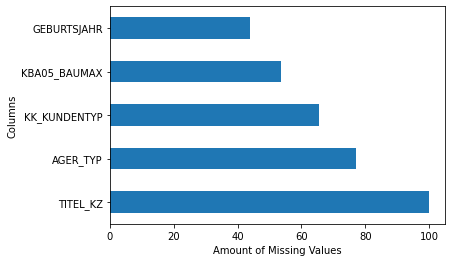

In [49]:
pct_miss_val.sort_values(ascending=False).head().plot.barh()
plt.ylabel('Columns')
plt.xlabel('Amount of Missing Values')
plt.show()

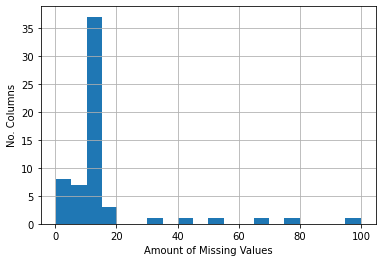

In [50]:
# Investigate patterns in the amount of missing data in each column.
pct_miss_val.hist(bins=20)
plt.ylabel('No. Columns')
plt.xlabel('Amount of Missing Values')
plt.show()

In [51]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
limit = round(pct_miss_val.quantile(0.75)*1.5)
columns_to_drop = list(pct_miss_val[pct_miss_val > limit].index)
print("Columns to drop: {}".format(columns_to_drop))

azdias.drop(columns_to_drop, axis=1, inplace=True)

Columns to drop: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


#### Discussion 1.1.2: Assess Missing Data in Each Column

the most of the columns have less than 20% missing values, we set limit to drop outliers from multiplying third quartile by 1.5 which is 20%, so we dropped columns with more than 20% missing values, there is 6 columns that has more that 20% missing values 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

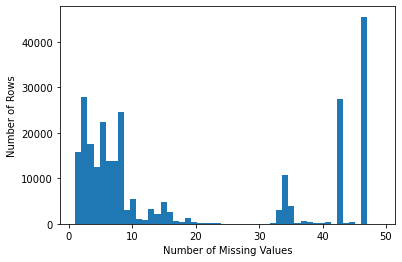

In [52]:
# How much data is missing in each row of the dataset?
missing_per_row = azdias.isnull().sum(axis=1)[azdias.isnull().sum(axis=1) > 0]
plt.hist(missing_per_row, bins=50)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

In [53]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 30
above_threshold = azdias[azdias.isnull().sum(axis=1) >= threshold]
below_threshold = azdias[azdias.isnull().sum(axis=1) < threshold]

In [54]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
zero_missing_coloumns = azdias.isnull().sum()[azdias.isnull().sum() == 0].index.tolist()
compare_columns = zero_missing_coloumns[:6]
compare_columns

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER']

In [55]:
def create_plot(column):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('missing values less than 30')
    sns.countplot(azdias.loc[below_threshold.index,column],ax=ax1)

    ax2.set_title('missing values above 30')
    sns.countplot(azdias.loc[above_threshold.index,column],ax=ax2)
    
    plt.show()

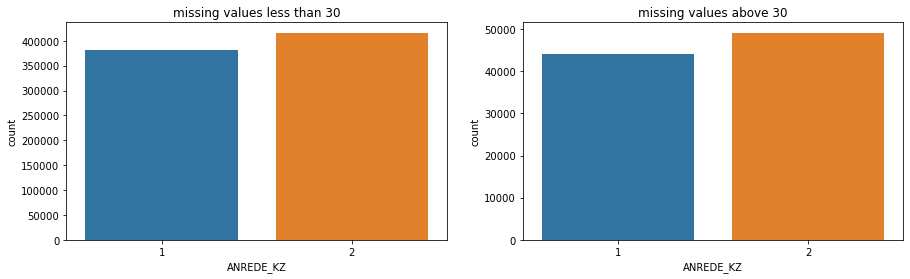

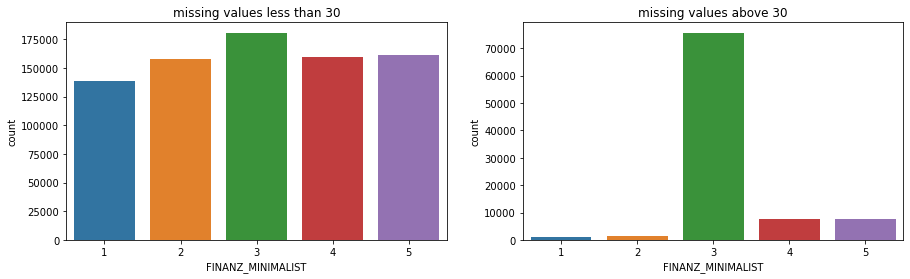

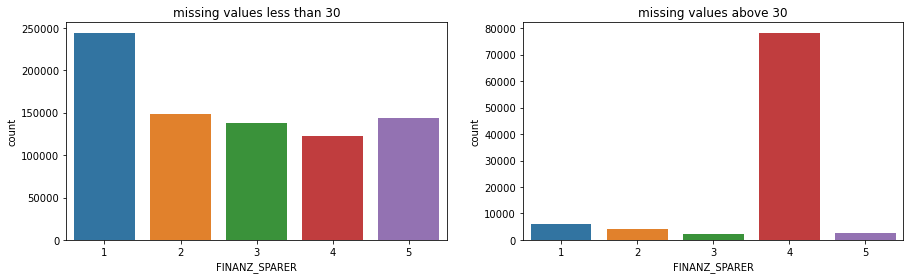

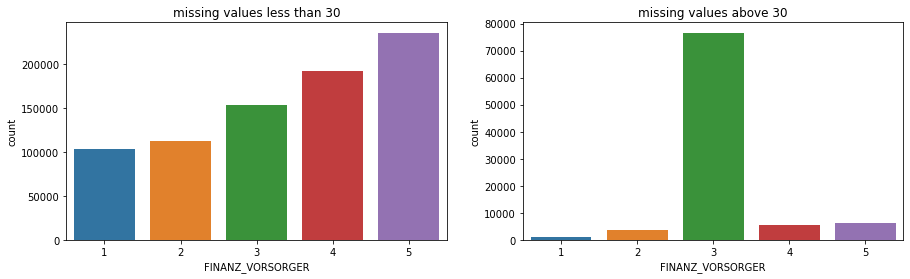

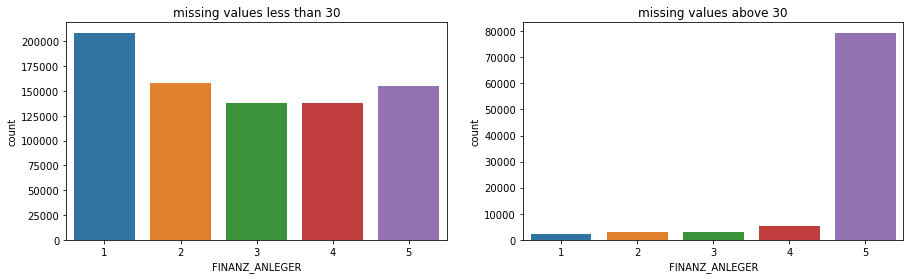

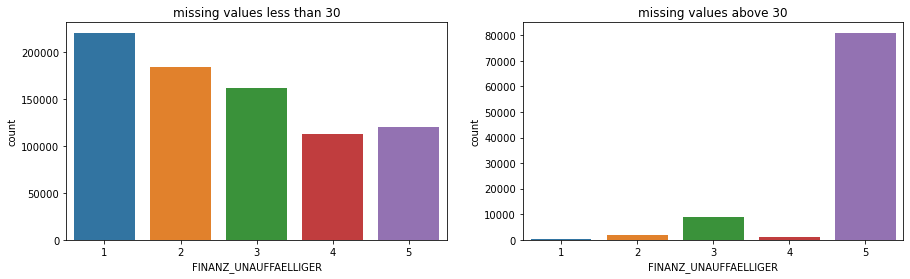

In [56]:
for col in compare_columns:
    create_plot(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

From the charts above, the distributions of values between the two datasets are similar for Gender feature, but are quite different for some features such as Financial features.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [57]:
above_threshold.reset_index(inplace=True, drop=True)
below_threshold.reset_index(inplace=True, drop=True)

In [58]:
# How many features are there of each data type?
# azdias.dtypes.value_counts()
feat_info=feat_info[feat_info.attribute.isin(below_threshold.columns)]
feat_info.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [59]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_var = feat_info[feat_info.type == 'categorical']
categorical_var

attribute information_level         type missing_or_unknown
2          ANREDE_KZ            person  categorical             [-1,0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical             [-1,0]
38       SHOPPER_TYP            person  categorical               [-1]
39           SOHO_KZ            person  categorical               [-1]
41          VERS_TYP            person  categorical               [-1]
42          ZABEOTYP            person  categorical             [-1,9]
52       GEBAEUDETYP          building  categorical             [-1,0]
55       OST_WEST_KZ          building  categorical               [-1]
57   CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]
58    CAMEO_DEU_2015     microcell_rr4  categorical               [XX]

In [21]:
above_threshold

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                       2.0          1            2.0                  3   
1                       2.0          1            6.0                  3   
2                       3.0          1            6.0                  3   
3                       2.0          1            6.0                  3   
4                       3.0          2            6.0                  3   
...                     ...        ...            ...                ...   
93155                   3.0          2            4.0                  3   
93156                   3.0          2            5.0                  4   
93157                   3.0          2            6.0                  3   
93158                   3.0          1            6.0                  3   
93159                   3.0          2            6.0                  3   

       FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0                  4                 3               5                      5   
1                  4                 3               5                      5   
2                  4                 3               5                      5   
3                  4                 3               5                      5   
4                  4                 3               5                      5   
...              ...               ...             ...                    ...   
93155              4                 3               5                      5   
93156              2                 3               5                      5   
93157              4                 3               5                      5   
93158              4                 3               5                      5   
93159              4                 3               5                      5   

       FINANZ_HAUSBAUER  FINANZTYP  ...  PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  \
0                     3          4  ...         NaN         NaN         NaN   
1                     3          4  ...         NaN         NaN         NaN   
2                     3          4  ...         NaN         NaN         NaN   
3                     3          4  ...         NaN         NaN         NaN   
4                     3          4  ...         NaN         NaN         NaN   
...                 ...        ...  ...         ...         ...         ...   
93155                 3          4  ...         NaN         NaN         NaN   
93156                 1          3  ...         NaN         NaN         NaN   
93157                 3          4  ...         NaN         NaN         NaN   
93158                 3          4  ...         NaN         NaN         NaN   
93159                 3          4  ...         NaN         NaN         NaN   

       PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  \
0             NaN          NaN       NaN       NaN     NaN          NaN   
1             NaN          NaN       NaN       NaN     NaN          NaN   
2             NaN          NaN       NaN       NaN     NaN          NaN   
3             NaN          NaN       NaN       NaN     NaN          NaN   
4             NaN          NaN       NaN       NaN     NaN          NaN   
...           ...          ...       ...       ...     ...          ...   
93155         NaN          NaN       NaN       NaN     NaN          NaN   
93156         NaN          NaN       NaN       NaN     NaN          NaN   
93157         NaN          NaN       NaN       NaN     NaN          NaN   
93158         NaN          NaN       NaN       NaN     NaN          NaN   
93159         NaN          NaN       NaN       NaN     NaN          NaN   

       RELAT_AB  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
93155       NaN  
93156       NaN  
93157       NaN  
93158       NaN  
93159       NaN  

[93160 rows x 79 columns]

In [61]:
binary_var = []
multi_var = []
for col in categorical_var.attribute:
    if below_threshold[col].nunique() == 2:
        binary_var.append(col)
    else:
        multi_var.append(col)

In [62]:
print(binary_var)
print(multi_var)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [63]:
for col in binary_var:
    print(below_threshold[col].value_counts())

2    416177
1    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    394238
1.0    367102
Name: VERS_TYP, dtype: int64
W    629520
O    168541
Name: OST_WEST_KZ, dtype: int64


In [64]:
# Re-encode categorical variable(s) to be kept in the analysis.

below_threshold["ANREDE_KZ"].replace({2:0,1:1},inplace=True)
below_threshold["SOHO_KZ"].replace({0.0:0,1.0:1},inplace=True)
below_threshold["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)#non numerical variables
below_threshold["OST_WEST_KZ"].astype('int')
below_threshold=pd.get_dummies(data=below_threshold,columns=multi_var)

In [65]:
below_threshold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798061 entries, 0 to 798060
Columns: 194 entries, ALTERSKATEGORIE_GROB to CAMEO_DEU_2015_9E
dtypes: float64(42), int64(23), object(1), uint8(128)
memory usage: 499.3+ MB


#### Discussion 1.2.1: Re-Encode Categorical Features


There is no features dropped, I re-encode binary features directly, and encode multi level features using get_dummies

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [66]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# .dtypes
mixed_var = feat_info[feat_info.type == 'mixed']
mixed_var

attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed                [0]
16    LP_LEBENSPHASE_GROB            person  mixed                [0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed             [-1,0]
56               WOHNLAGE          building  mixed               [-1]
59        CAMEO_INTL_2015     microcell_rr4  mixed            [-1,XX]
79            PLZ8_BAUMAX    macrocell_plz8  mixed             [-1,0]

In [67]:
below_threshold['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182983
8.0     141630
10.0     85808
5.0      84691
3.0      53845
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

#### PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)


In [68]:
decade_dic={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
movement_dic={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}

below_threshold["DECADE"]=below_threshold.PRAEGENDE_JUGENDJAHRE
below_threshold["MOVEMENT"]=below_threshold.PRAEGENDE_JUGENDJAHRE

below_threshold["DECADE"].replace(decade_dic,inplace=True)
below_threshold["MOVEMENT"].replace(movement_dic,inplace=True)

In [69]:
del below_threshold["PRAEGENDE_JUGENDJAHRE"]

In [70]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
below_threshold['CAMEO_INTL_2015'].dtypes


dtype('O')

#### CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [71]:
# Wealth and Life Stage dict
wealth_dic={'11':1,'12':1,'13':1,'14':1,'15':1,
            '21':2,'22':2,'23':2,'24':2,'25':2,
            '31':3,'32':3,'33':3,'34':3,'35':3,
            '41':4,'42':4,'43':4,'44':4,'45':4,
            '51':5,'52':5,'53':5,'54':5,'55':5
            }
life_dic={'11':1,'12':2,'13':3,'14':4,'15':5,
            '21':1,'22':2,'23':3,'24':4,'25':5,
            '31':1,'32':2,'33':4,'34':4,'35':5,
            '41':1,'42':2,'43':3,'44':4,'45':5,
            '51':1,'52':2,'53':3,'54':4,'55':5
            }

#create two features
below_threshold["WEALTH"]=below_threshold.CAMEO_INTL_2015
below_threshold["LIFE_STAGE"]=below_threshold.CAMEO_INTL_2015
#replace with new variables
below_threshold["WEALTH"].replace(wealth_dic,inplace=True)
below_threshold["LIFE_STAGE"].replace(life_dic,inplace=True)
#drop the CAMEO_INTL_2015 column
below_threshold.drop("CAMEO_INTL_2015",axis=1,inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

the steps which I used to engineer the mixed-type features as following:

    1. create dictionary for each variable
    2. create two variables for each mixed-type features
    3. replace values the mixed-type in a new feature by the new values in dictionaries
    4. drop the mixed-type columns

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [72]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
for mixed_feature in mixed_var["attribute"]:
    if mixed_feature in below_threshold.columns:
        below_threshold.drop(mixed_feature,axis=1,inplace=True)

In [73]:
below_threshold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798061 entries, 0 to 798060
Columns: 192 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(41), int64(23), uint8(128)
memory usage: 487.1 MB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [3]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for att, miss_val in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        miss_val = miss_val.strip('[]').split(',')
        miss_val = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in miss_val]
        if miss_val != ['']:
            df.replace({att: miss_val}, np.nan, inplace=True)
    
    # remove selected columns and rows, ...
    # remove columns
    pct_miss_val = df.isnull().sum()[df.isnull().sum() > 0]/df.shape[0] * 100
    limit = round(pct_miss_val.quantile(0.75)*1.5)
    columns_to_drop = list(pct_miss_val[pct_miss_val > limit].index)
    df.drop(columns_to_drop, axis=1, inplace=True)
    
    # remove rows
    threshold = 30
    below_threshold = df[df.isnull().sum(axis=1) < threshold]
    below_threshold.reset_index(inplace=True, drop=True)

    # select, re-encode, and engineer column values.
    feat_info=feat_info[feat_info.attribute.isin(below_threshold.columns)]
    # categorical
    categorical_var = feat_info[feat_info.type == 'categorical']
    binary_var = []
    multi_var = []
    for col in categorical_var.attribute:
        if below_threshold[col].nunique() == 2:
            binary_var.append(col)
        else:
            multi_var.append(col)
    below_threshold["ANREDE_KZ"].replace({2:0,1:1},inplace=True)
    below_threshold["SOHO_KZ"].replace({0.0:0,1.0:1},inplace=True)
    below_threshold["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)#non numerical variables
    below_threshold["OST_WEST_KZ"].astype('int')
    below_threshold=pd.get_dummies(data=below_threshold,columns=multi_var)
    
    # Mixed
    mixed_var = feat_info[feat_info.type == 'mixed']
    decade_dic={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    movement_dic={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}

    below_threshold["DECADE"]=below_threshold.PRAEGENDE_JUGENDJAHRE
    below_threshold["MOVEMENT"]=below_threshold.PRAEGENDE_JUGENDJAHRE

    below_threshold["DECADE"].replace(decade_dic,inplace=True)
    below_threshold["MOVEMENT"].replace(movement_dic,inplace=True)
    del below_threshold["PRAEGENDE_JUGENDJAHRE"]
    
    wealth_dic={'11':1,'12':1,'13':1,'14':1,'15':1,
                '21':2,'22':2,'23':2,'24':2,'25':2,
                '31':3,'32':3,'33':3,'34':3,'35':3,
                '41':4,'42':4,'43':4,'44':4,'45':4,
                '51':5,'52':5,'53':5,'54':5,'55':5
                }
    life_dic={'11':1,'12':2,'13':3,'14':4,'15':5,
                '21':1,'22':2,'23':3,'24':4,'25':5,
                '31':1,'32':2,'33':4,'34':4,'35':5,
                '41':1,'42':2,'43':3,'44':4,'45':5,
                '51':1,'52':2,'53':3,'54':4,'55':5
                }

    #create two features
    below_threshold["WEALTH"]=below_threshold.CAMEO_INTL_2015
    below_threshold["LIFE_STAGE"]=below_threshold.CAMEO_INTL_2015
    #replace with new variables
    below_threshold["WEALTH"].replace(wealth_dic,inplace=True)
    below_threshold["LIFE_STAGE"].replace(life_dic,inplace=True)
    #drop the CAMEO_INTL_2015 column
    below_threshold.drop("CAMEO_INTL_2015",axis=1,inplace=True)
    
    
    for mixed_feature in mixed_var["attribute"]:
        if mixed_feature in below_threshold.columns:
            below_threshold.drop(mixed_feature,axis=1,inplace=True)

    # Return the cleaned dataframe.
    return below_threshold
    

In [4]:
azdias = pd.read_csv('../data_project3/Udacity_AZDIAS_Subset.csv', delimiter=';')
feat_info = pd.read_csv('../data_project3/AZDIAS_Feature_Summary.csv', delimiter=';')
azdias_cleaned = clean_data(azdias,feat_info)

In [5]:
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798061 entries, 0 to 798060
Columns: 192 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(41), int64(23), uint8(128)
memory usage: 487.1 MB


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [6]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

miss_azdias_cleaned = azdias_cleaned.isnull().sum()[azdias_cleaned.isnull().sum() > 0].sort_values() / len(azdias_cleaned)*100
miss_azdias_cleaned

GEBAEUDETYP_RASTER      0.000877
KONSUMNAEHE             0.008897
INNENSTADT              0.074180
EWDICHTE                0.074180
BALLRAUM                0.074180
ALTERSKATEGORIE_GROB    0.351226
ANZ_HH_TITEL            0.483296
ORTSGR_KLS9             0.517003
RELAT_AB                0.529659
ARBEIT                  0.529659
RETOURTYP_BK_S          0.594566
ONLINE_AFFINITAET       0.594566
WEALTH                  0.776632
LIFE_STAGE              0.776632
ANZ_HAUSHALTE_AKTIV     0.809462
KBA13_ANZAHL_PKW        1.583964
PLZ8_ANTG3              2.926468
PLZ8_GBZ                2.926468
PLZ8_ANTG1              2.926468
PLZ8_ANTG2              2.926468
PLZ8_HHZ                2.926468
PLZ8_ANTG4              2.926468
MOVEMENT                3.603108
DECADE                  3.603108
HEALTH_TYP              4.601277
VERS_TYP                4.601277
KBA05_ANTG4             5.032698
MOBI_REGIO              5.032698
KBA05_ANTG1             5.032698
KBA05_ANTG2             5.032698
KBA05_ANTG

In [7]:
miss_azdias_cleaned.index.shape

(35,)

In [8]:
numeric_var = feat_info[feat_info.type == 'numeric']
ordinal_var = feat_info[feat_info.type == 'ordinal']
categorical_var = feat_info[feat_info.type == 'categorical']

In [9]:
 miss_azdias_cleaned.index.isin(numeric_var.attribute).sum()

3

In [10]:
 miss_azdias_cleaned.index.isin(ordinal_var.attribute).sum()

27

In [11]:
 miss_azdias_cleaned.index.isin(categorical_var.attribute).sum()

1

In [12]:
imputer = SimpleImputer( strategy='most_frequent') #for median imputation replace 'mean' with 'median'
imputer.fit(azdias_cleaned)
imputed_azdias = imputer.transform(azdias_cleaned)
imputed_azdias

array([[1., 0., 1., ..., 1., 5., 1.],
       [3., 0., 1., ..., 0., 2., 4.],
       [4., 0., 4., ..., 1., 1., 2.],
       ...,
       [2., 0., 2., ..., 1., 2., 4.],
       [1., 1., 1., ..., 1., 5., 1.],
       [4., 1., 4., ..., 1., 4., 3.]])

In [13]:
imputed_azdias.shape

(798061, 192)

In [14]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
scaled_azdias = scaler.fit_transform(imputed_azdias)

In [15]:
scaled_azdias.shape

(798061, 192)

In [16]:
scaled_azdias=pd.DataFrame(scaled_azdias,columns=azdias_cleaned.columns.tolist())
scaled_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798061 entries, 0 to 798060
Columns: 192 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(192)
memory usage: 1.1 GB


### Discussion 2.1: Apply Feature Scaling

I've filled the NaN values with the mode of each feature using the Imputer instance. Surprisingly, there were so many NaN values in the dataset relative to the number of observations.

Moreover, each feature has been scaled to mean 0 and standard deviation 1, using StandardScaler instance.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [103]:
# Apply PCA to the data.
pca = PCA()
pca.fit(scaled_azdias)

PCA()

In [107]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
#     for i in range(num_components):
#         ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


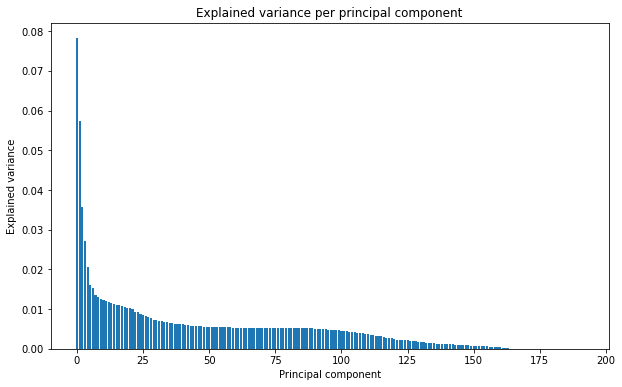

In [106]:
num_components=np.arange(len(pca.explained_variance_ratio_))
values=pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(num_components,values)
plt.xlabel("Principal component")
plt.ylabel("Explained variance")
plt.title("Explained variance per principal component")
plt.show()

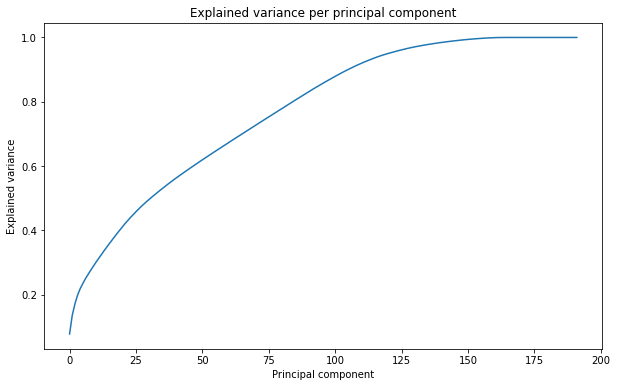

In [110]:
cumvals = np.cumsum(values)
plt.figure(figsize=(10, 6))
plt.plot(num_components,cumvals)
plt.xlabel("Principal component")
plt.ylabel("Explained variance")
plt.title("Explained variance per principal component")
plt.show()

In [121]:
np. where(cumvals > 0.8)

(array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
        123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
        149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
        162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
        188, 189, 190, 191], dtype=int64),)

In [17]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 84)
azdias_pca = pca.fit_transform(scaled_azdias)

### Discussion 2.2: Perform Dimensionality Reduction

We've retained 84 components, which is half the number of features that we have. And from that, we've got cumulative variance explained the original data about 80%

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [18]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def PCA_weights(df,pca,n):
    weights_df=pd.DataFrame(pca.components_,columns=list(df.columns)).iloc[n]
    weights_df.sort_values(ascending=False, inplace=True)
    return weights_df

def plot_component_weights(df, pca, component, feature_plot):
    component_weights = PCA_weights(df, pca, component)
    component_weights = pd.concat([component_weights.head(feature_plot), component_weights.tail(feature_plot)])
    
    df = pd.DataFrame({'Top {} Features'.format(feature_plot): component_weights[:feature_plot],
                   'Bottom {} Features'.format(feature_plot): component_weights[feature_plot:]},
                      index=component_weights.index)
    df.plot.bar(rot=90,figsize=(10,6))
    plt.title('Component {}'.format(component+1))
    plt.ylabel('Weight')
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()
    
    return component_weights

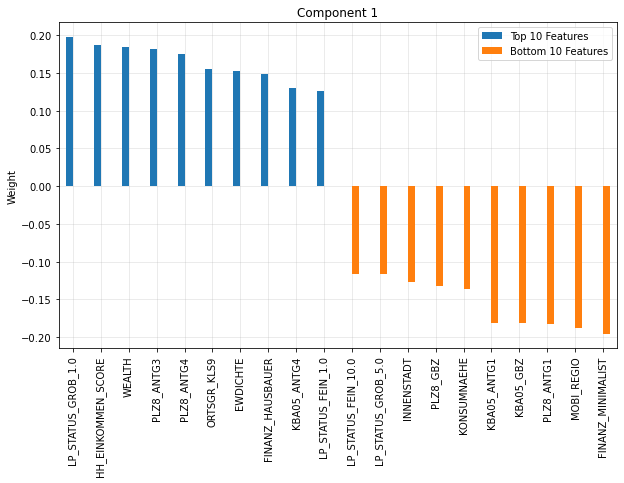

LP_STATUS_GROB_1.0     0.197367
HH_EINKOMMEN_SCORE     0.186339
WEALTH                 0.184847
PLZ8_ANTG3             0.181329
PLZ8_ANTG4             0.174985
ORTSGR_KLS9            0.154529
EWDICHTE               0.152958
FINANZ_HAUSBAUER       0.148425
KBA05_ANTG4            0.129460
LP_STATUS_FEIN_1.0     0.126266
LP_STATUS_FEIN_10.0   -0.116274
LP_STATUS_GROB_5.0    -0.116274
INNENSTADT            -0.127352
PLZ8_GBZ              -0.132621
KONSUMNAEHE           -0.136405
KBA05_ANTG1           -0.180748
KBA05_GBZ             -0.181293
PLZ8_ANTG1            -0.182574
MOBI_REGIO            -0.188097
FINANZ_MINIMALIST     -0.195250
Name: 0, dtype: float64

In [19]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc1_weights = plot_component_weights(scaled_azdias,pca,0, 10)
pc1_weights

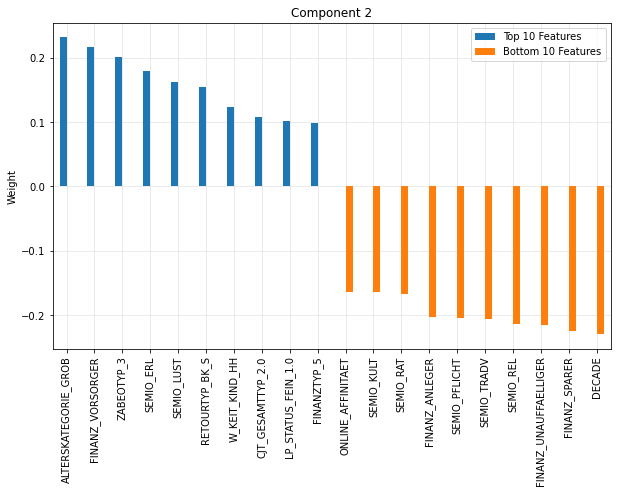

ALTERSKATEGORIE_GROB     0.231218
FINANZ_VORSORGER         0.217181
ZABEOTYP_3               0.200279
SEMIO_ERL                0.179633
SEMIO_LUST               0.161927
RETOURTYP_BK_S           0.154926
W_KEIT_KIND_HH           0.123354
CJT_GESAMTTYP_2.0        0.107537
LP_STATUS_FEIN_1.0       0.101320
FINANZTYP_5              0.098521
ONLINE_AFFINITAET       -0.163690
SEMIO_KULT              -0.164488
SEMIO_RAT               -0.166749
FINANZ_ANLEGER          -0.202937
SEMIO_PFLICHT           -0.204095
SEMIO_TRADV             -0.206609
SEMIO_REL               -0.213656
FINANZ_UNAUFFAELLIGER   -0.214865
FINANZ_SPARER           -0.224606
DECADE                  -0.229151
Name: 1, dtype: float64

In [21]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc2_weights = plot_component_weights(scaled_azdias,pca,1, 10)
pc2_weights

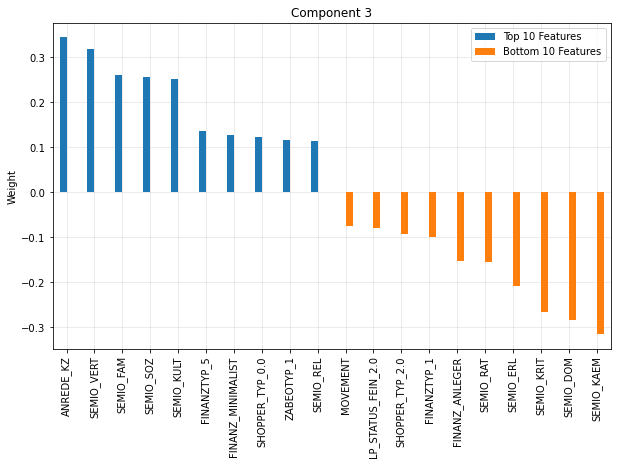

ANREDE_KZ             0.344746
SEMIO_VERT            0.318774
SEMIO_FAM             0.260605
SEMIO_SOZ             0.257107
SEMIO_KULT            0.251671
FINANZTYP_5           0.135411
FINANZ_MINIMALIST     0.127834
SHOPPER_TYP_0.0       0.122543
ZABEOTYP_1            0.115931
SEMIO_REL             0.113075
MOVEMENT             -0.074231
LP_STATUS_FEIN_2.0   -0.078800
SHOPPER_TYP_2.0      -0.092662
FINANZTYP_1          -0.099906
FINANZ_ANLEGER       -0.153358
SEMIO_RAT            -0.154172
SEMIO_ERL            -0.208251
SEMIO_KRIT           -0.267119
SEMIO_DOM            -0.283666
SEMIO_KAEM           -0.314769
Name: 2, dtype: float64

In [22]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc3_weights = plot_component_weights(scaled_azdias,pca,2, 10)
pc3_weights


### Discussion 2.3: Interpret Principal Components

1. First principal component
    * I can interpret this component with positive values as follow:
        * LP_STATUS_GROB_1.0 (Social status:low-income earners)
        * HH_EINKOMMEN_SCORE (Estimated household net income)
        * WEALTH(Households wealth)
        * PLZ8_ANTG3(Number of 6-10 family houses in the PLZ8 region)
    * and can interpret with negative values as follow:
        * FINANZ_MINIMALIST(Financial typology:low financial interest)
        * MOBI_REGIO(Movement patterns)
        * PLZ8_ANTG1(Number of 1-2 family houses in the PLZ8 region)
        * KBA05_GBZ(Number of buildings in the microcell)
    we can notice the first component has a relationship with a number of buildings, family, social status, income, and wealth.
    
    
2. Second principal component
    * I can interpret this component with positive values as follow:
        * ALTERSKATEGORIE_GROB(Estimated age based on given name analysis)
        * FINANZ_VORSORGER(Financial typology:be prepared)
        * ZABEOTYP_3.0(Energy consumption typology:fair supplied)
        * SEMIO_ERL(Personality typology:event-oriented)
    * and can interpret with negative values as follow:
        * DECADE(generation)
        * FINANZ_SPARER(Financial typology:money-saver)
        * FINANZ_UNAUFFAELLIGER(Financial typology:inconspicuous)
        * SEMIO_REL(Personality typology:religious)
    we can notice the second component has a relationship with Financial typology, Personality typology, age, energy consumption, and decade.
    
    
3. Third principal component
    * I can interpret this component with positive values as follow:
        * ANREDE_KZ(Gender:femal,male)
        * SEMIO_VERT(Personality typology:dreamful)
        * SEMIO_FAM (Personality typology:family-minded)
        * SEMIO_SOZ (Personality typology:socially-minded)
    * and can interpret with negative values as follow:
        * SEMIO_KAEM (Personality typology:combative attitude)
        * SEMIO_DOM (Personality typology:dominant-minded)
        * SEMIO_KRIT (Personality typology:critical-minded)
        * SEMIO_ERL (Personality typology:event-oriented)
    we can notice the third component has a strong relationship with Personality typology and gender.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [171]:
list(range(2,21,2))

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

In [174]:
scores = []
n_clusters = list(range(2,21,2))
# Over a number of different cluster counts...
for i in tqdm(n_clusters):

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(azdias_pca)
    scores.append(round(kmeans.score(azdias_pca)))
    
    # compute the average within-cluster distances.
#     print('Number of cluster: {}, cluster distance {}'.format(i, kmeans.score(azdias_pca)))
    

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [24:25<00:00, 146.52s/it]


In [177]:
scores

[-112079308,
 -104667841,
 -100785828,
 -98390402,
 -95889327,
 -94604069,
 -92919303,
 -92056896,
 -90895329,
 -90146839]

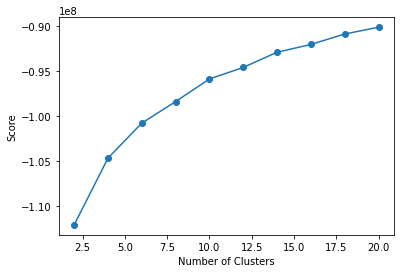

In [176]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(n_clusters, scores, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()


In [23]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 14)
model = kmeans.fit(azdias_pca)
predections_azdias_data = model.predict(azdias_pca)

In [202]:
predections_azdias_data.shape

(798061,)

### Discussion 3.1: Apply Clustering to General Population

We can't know exactly where the elbow in the plot, but we can actually suggest that could 14. So, we've decided to segment the population by this number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [24]:
# Load in the customer demographics data.
customers = pd.read_csv('../data_project3/Udacity_CUSTOMERS_Subset.csv', delimiter = ';')
feat_info = pd.read_csv('../data_project3/AZDIAS_Feature_Summary.csv', delimiter=';')
customers.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2  ...         3.0         3.0   
1                      3                 2  ...         NaN         NaN   
2                      4                 4  ...         2.0         3.0   
3                      1                 2  ...         3.0         2.0   
4                      5                 2  ...         2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0       5.0     1.0   
1         NaN         NaN          NaN       NaN       NaN     NaN   
2         3.0         1.0          3.0       3.0       2.0     3.0   
3         1.0         0.0          1.0       3.0       4.0     1.0   
4         2.0         1.0          2.0       3.0       3.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  
2          5.0       3.0  
3          3.0       1.0  
4          5.0       1.0  

[5 rows x 85 columns]

In [217]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
from sklearn.pipeline import Pipeline
def segments(df, feat_info):
    df_cleaned = clean_data(df,feat_info)
    pipe_processing = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                     ('scaler', StandardScaler())])
    processed = pipe_processing.fit_transform(df_cleaned)
    pipe_predict = Pipeline([('pca', pca),
                             ('kmeans', model)])
    pred = pipe_predict.predict(processed)
    return df_cleaned, pred

In [25]:
customers_cleaned = clean_data(customers,feat_info)
customer_imputed = imputer.fit_transform(customers_cleaned)
customer_scaled = scaler.fit_transform(customer_imputed)
customer_pca = pca.transform(customer_scaled)
pred = model.predict(customer_pca)

In [218]:
customers_cleaned, pred = segments(customers, feat_info)

In [26]:
pred.shape

(141725,)

In [27]:
customers_cleaned.shape

(141725, 192)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [28]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
def compare_plot(general,customers):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('General Clusters')
    sns.countplot(general,ax=ax1)

    ax2.set_title('Customers Clusters')
    sns.countplot(customers,ax=ax2)
    plt.show()


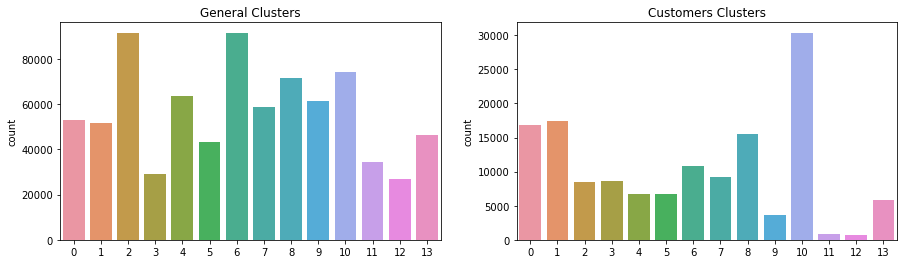

In [29]:
compare_plot(predections_azdias_data,pred)

In [72]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_10 = model.cluster_centers_[10]
pca_10 = pca.inverse_transform(cluster_10)
overrepresented = scaler.inverse_transform(pca_10)

overrepresented = pd.Series(data = overrepresented, index = customers_cleaned.columns)
overrepresented.iloc[85:145]


LP_FAMILIE_FEIN_1.0     0.285253
LP_FAMILIE_FEIN_2.0     0.169068
LP_FAMILIE_FEIN_3.0    -0.002864
LP_FAMILIE_FEIN_4.0    -0.004019
LP_FAMILIE_FEIN_5.0     0.000824
LP_FAMILIE_FEIN_6.0    -0.000996
LP_FAMILIE_FEIN_7.0    -0.000406
LP_FAMILIE_FEIN_8.0     0.029707
LP_FAMILIE_FEIN_9.0    -0.004363
LP_FAMILIE_FEIN_10.0    0.173962
LP_FAMILIE_FEIN_11.0    0.256296
LP_FAMILIE_GROB_1.0     0.285253
LP_FAMILIE_GROB_2.0     0.118888
LP_FAMILIE_GROB_3.0    -0.007952
LP_FAMILIE_GROB_4.0     0.003579
LP_FAMILIE_GROB_5.0     1.117724
LP_STATUS_FEIN_1.0     -0.014273
LP_STATUS_FEIN_2.0     -0.014472
LP_STATUS_FEIN_3.0      0.013380
LP_STATUS_FEIN_4.0     -0.008216
LP_STATUS_FEIN_5.0     -0.004724
LP_STATUS_FEIN_6.0      0.026760
LP_STATUS_FEIN_7.0      0.048272
LP_STATUS_FEIN_8.0     -0.021617
LP_STATUS_FEIN_9.0      0.083471
LP_STATUS_FEIN_10.0     0.848490
LP_STATUS_GROB_1.0     -0.027069
LP_STATUS_GROB_2.0      0.082845
LP_STATUS_GROB_3.0     -0.006751
LP_STATUS_GROB_4.0      0.087942
LP_STATUS_

In [52]:
# overrepresented.shape
overrepresented[overrepresented.index == 'LIFE_STAGE']

LIFE_STAGE    2.896663
dtype: float64

In [71]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_12 = model.cluster_centers_[12]
pca_12 = pca.inverse_transform(cluster_12)
underrepresented = scaler.inverse_transform(pca_12)

underrepresented = pd.Series(data = underrepresented, index = customers_cleaned.columns)
underrepresented.iloc[85:145]


LP_FAMILIE_FEIN_1.0     0.103628
LP_FAMILIE_FEIN_2.0     1.039409
LP_FAMILIE_FEIN_3.0     0.105518
LP_FAMILIE_FEIN_4.0     0.207101
LP_FAMILIE_FEIN_5.0    -0.003409
LP_FAMILIE_FEIN_6.0    -0.014661
LP_FAMILIE_FEIN_7.0    -0.001887
LP_FAMILIE_FEIN_8.0     0.008670
LP_FAMILIE_FEIN_9.0    -0.035847
LP_FAMILIE_FEIN_10.0    0.097459
LP_FAMILIE_FEIN_11.0   -0.216747
LP_FAMILIE_GROB_1.0     0.103628
LP_FAMILIE_GROB_2.0     2.259155
LP_FAMILIE_GROB_3.0    -0.023202
LP_FAMILIE_GROB_4.0    -0.077330
LP_FAMILIE_GROB_5.0     0.306166
LP_STATUS_FEIN_1.0      0.245107
LP_STATUS_FEIN_2.0     -0.005064
LP_STATUS_FEIN_3.0      0.138932
LP_STATUS_FEIN_4.0      0.073315
LP_STATUS_FEIN_5.0     -0.000208
LP_STATUS_FEIN_6.0      0.027670
LP_STATUS_FEIN_7.0      0.063612
LP_STATUS_FEIN_8.0      0.002736
LP_STATUS_FEIN_9.0      0.178283
LP_STATUS_FEIN_10.0     0.400321
LP_STATUS_GROB_1.0      0.167845
LP_STATUS_GROB_2.0      0.100927
LP_STATUS_GROB_3.0      0.097042
LP_STATUS_GROB_4.0      0.183616
LP_STATUS_

In [53]:
underrepresented[underrepresented.index == 'LIFE_STAGE']

LIFE_STAGE    3.364487
dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

The clusters where the mail order company should stray from are 9,11,2 since they are the most underrepresented clusters. However, the company should target clusters 0, 1, 8, 10 as they are overrepresented.

* Cluster 10 is overrepresnted in the customer data
    * ANREDE_KZ = 1.100407 &rarr; **(Gender: Male)** 
    * ALTERSKATEGORIE_GROB = 3.780435 &rarr; **(Estimated age: > 60 years old)** 
    * WEALTH = 3.700425 &rarr; **(Wealth: Less Affluent Households)**  
    * LIFE_STAGE = 2.896663 &rarr; **(Life Stage: Families With School Age Children)** 
    * KKK = 1.632121 &rarr; **(Purchasing power in region: High)**
    * REGIOTYP = 3.611853 &rarr; **(Neighborhood typology: Middle Class)**
    * CAMEO_DEUG_2015 &rarr; **(Wealth / Life Stage Typology, rough scale: Working Class)**
    * GEBAEUDETYP &rarr; **(Type of building: Residential Building)**
    * LP_STATUS_GROB &rarr; **(Social status: Top Earners)**
    * LP_FAMILIE_GROB &rarr; **(Family type: Multiperson Household)**
    

* Cluster 12 is underrepresented in the customer data
    * ANREDE_KZ = 0.484043 &rarr; **(Gender: Female)** 
    * ALTERSKATEGORIE_GROB = 3.119770 &rarr; **(Estimated age: 40 - 60 years old)** 
    * WEALTH = 2.51473 &rarr; **(Wealth: Comfortable Households)** 
    * LIFE_STAGE = 3.364487 &rarr; **(Life Stage: Families With School Age Children)**
    * KKK = 2.457065 &rarr; **(Purchasing power in region: High)**
    * REGIOTYP = 4.219824 &rarr; **(Neighborhood typology: Middle Class)**
    * CAMEO_DEUG_2015 &rarr; **(Wealth / Life Stage Typology, rough scale: Consumption-oriented Middleclass)**
    * GEBAEUDETYP &rarr; **(Type of building: Residential Building)**
    * LP_STATUS_GROB &rarr; **(Social status: Top Earners)**
    * LP_FAMILIE_GROB &rarr; **(Family type: Couple)**


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.